# What explains variation in land rents?

In [1]:
import geopandas
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
from sklearn.linear_model import LinearRegression
from ipywidgets import interact_manual
import ipywidgets as widgets
from variables import data_labels, m

## Data
The program requires a GeoPandas DataFrame which contains at least the following:
- a column containing **shapes**, which are used for the different plots.
- a column ```p_m2_FE``` containing **land rents**, which are used for the economic analysis.
- at least two columns containing ***explanatory variables***, which can be used to investigate their effect on land rents.
    - The program theoretically allows for unlimited statistics.

In [2]:
# import source for shapefiles of zip codes and for statistics per zip code
data = geopandas.read_file('data/cbs_pc4_2018_v3.shp')
data.replace(-99997, np.nan, inplace=True)   # change NaN-value placeholders from dataset to NaN

# add source for land rents per postal code
land_rents  = pd.read_excel('data/Weighted_avg_landprice_pc4_1985-2007.xls', sheet_name='Data')
data = pd.merge(data, land_rents, left_on='PC4', right_on='PC4Code', suffixes=(None,'_VU')).drop('PC4Code', axis=1)

# calculate area and population density using the shapefile and population data as this data is not present in the dataset
data['km2'] = data.to_crs('epsg:32633').geometry.area / 1_000_000 
data['pop_density'] = data.INWONER/data.km2

data = data.set_index('PC4')

## Chapter 1: Introduction

To begin the analysis it is useful to plot the land rents and other variables on a map. This gives a general idea of the dataset you are using and is useful to better be able to analyse further (more complicated) results or figures.

### 1.1 Plot a column from the GeoPandas DataFrame to a map
**Note**
- A logaritmhic scale is used because this allows for better readability of the maps in this dataset. This might not always be the case.

In [3]:
# the pyplot resolution setting is changed to 300 for higher quality plots which is necessary for the large maps
plt.rcParams['figure.dpi'] = 300  # dpi = dots per inch

In [4]:
def plot(column, n):
    '''Plot column of the DataFrame to a map'''
    data.plot(column=column, legend=True, 
              norm=matplotlib.colors.LogNorm(vmin=data[column].min(), vmax=data[column].max())
             )
    ax = plt.gca()
    ax.set_title('Figure ' + n + ': ' + data_labels.get(column, column) + ' on 4-digit zip code level')
    ax.set_axis_off()
    plt.show()

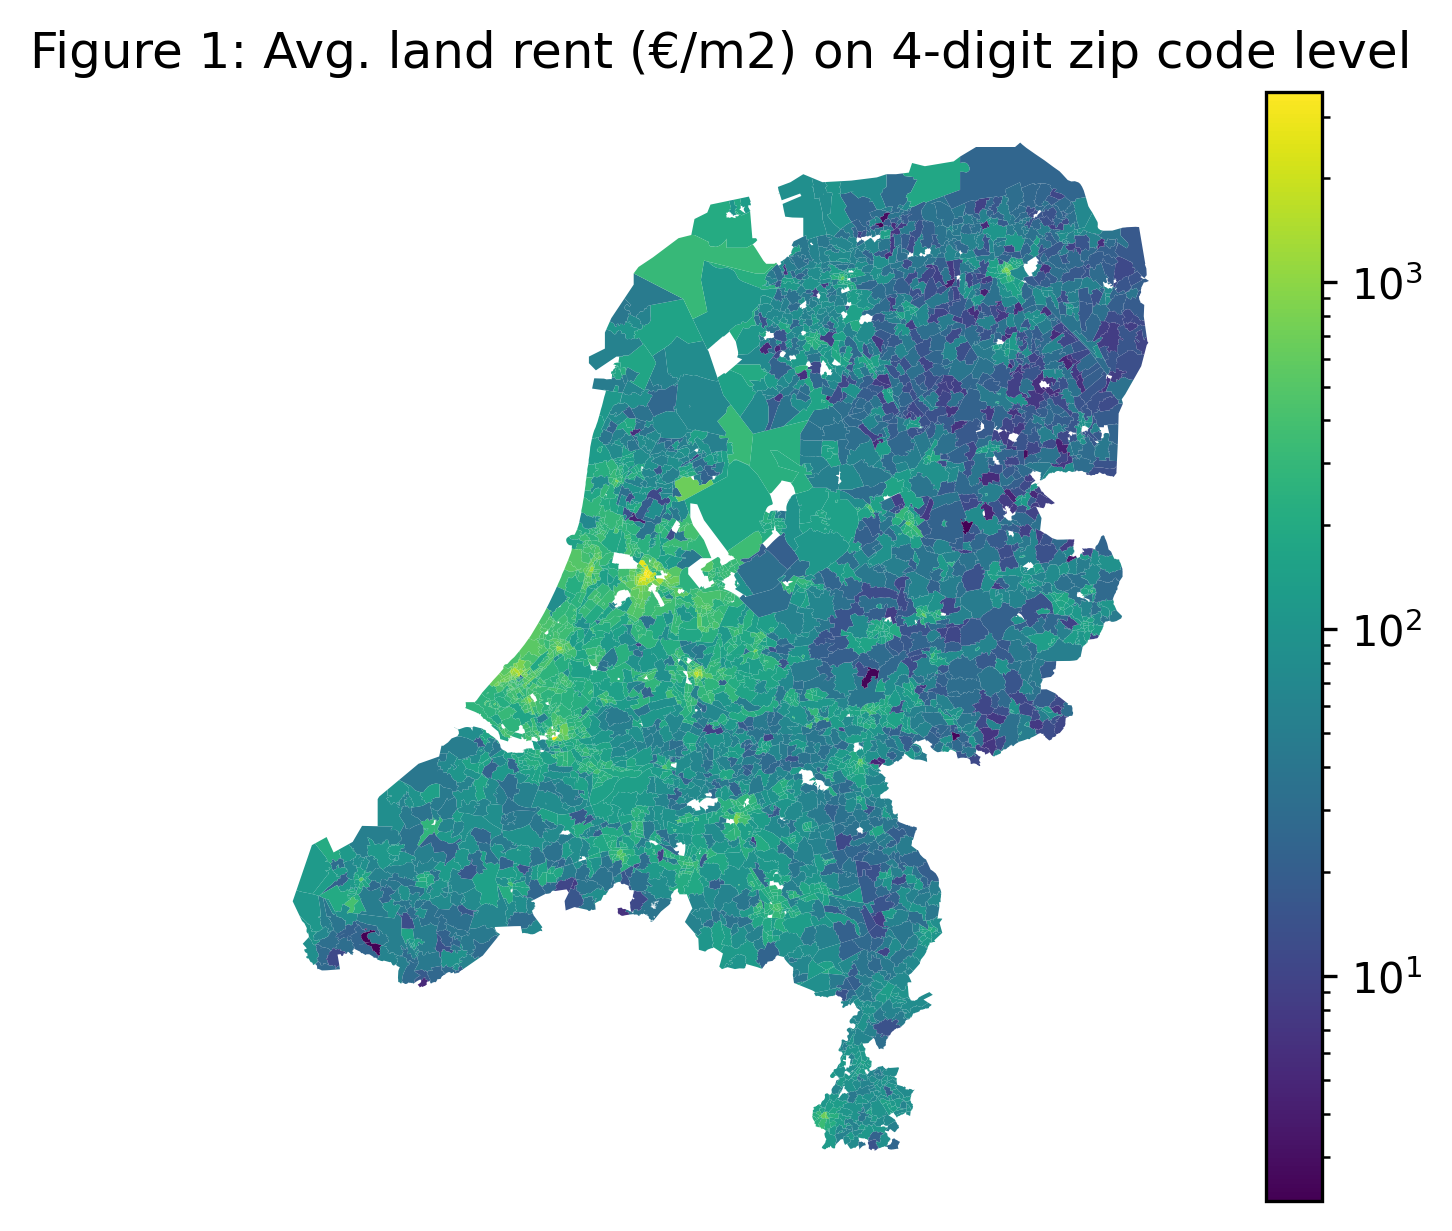

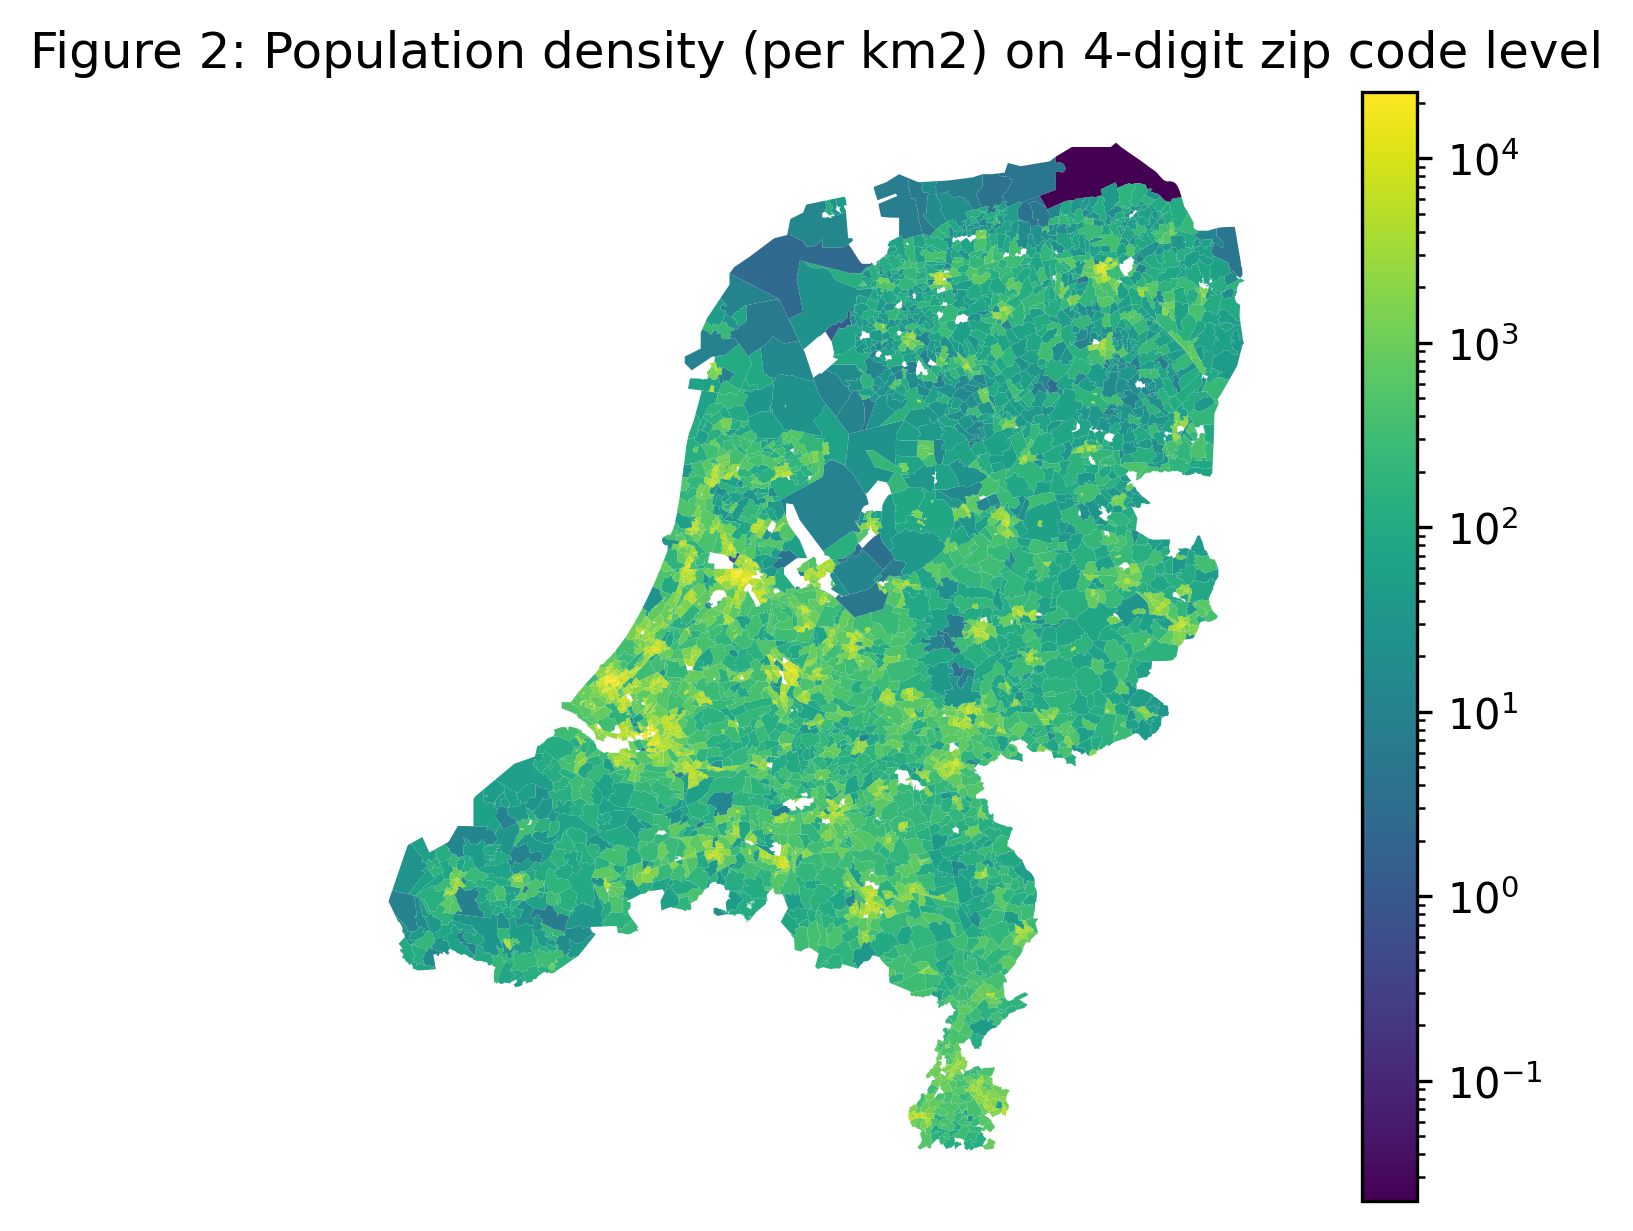

In [5]:
plot('p_m2_FE', '1')
plot('pop_density', '2')

**Conclusions**
- Figure 1 shows that land rent is higher in and around major cities such as Amsterdam, The Hague, Rotterdam and Utrecht.
- Figure 2 shows that these areas are also densely populated. There seems to be a correlation or association between these variables.

### 1.2 Plot the relation between a variable and land rent
We can visualize the relation between a variable and land rent in a scatter plot to see whether a correlation or association between the variables is present. An Ordinary Least Squares (OLS) regression model is used to draw a trendline through the data.

In [6]:
def plot_relation(data, column, title=''):
    '''Plot a log log scatter plot of column to p_m2_FE from data 
    and draw a Ordinary Least Squares (OLS) regression trendline'''
    data_temp = data.dropna(subset=column)

    fig = px.scatter(data_temp, x=column, y='p_m2_FE', trendline="ols", log_x=True, log_y=True,
                     trendline_options=dict(log_x=True, log_y=True), trendline_color_override='red',
                     labels=data_labels, title=title)
    fig.show()

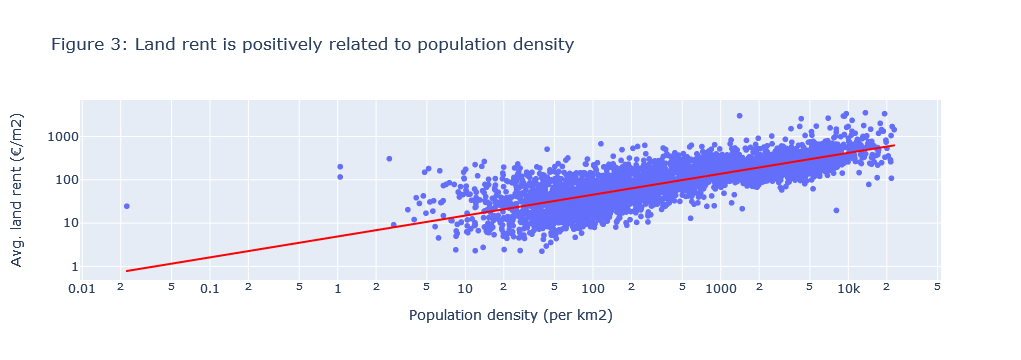

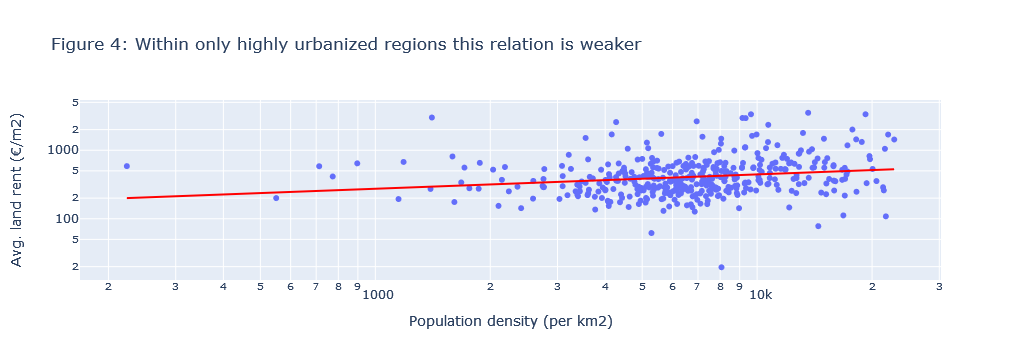

In [7]:
plot_relation(data, 'pop_density', 'Figure 3: Land rent is positively related to population density')

# a selection of the dataset can be passed as an argument. ```STED``` is a measurement of how urbanized a postal code is
plot_relation(data[data['STED'] == 1], 'pop_density', 'Figure 4: Within only highly urbanized regions this relation is weaker')

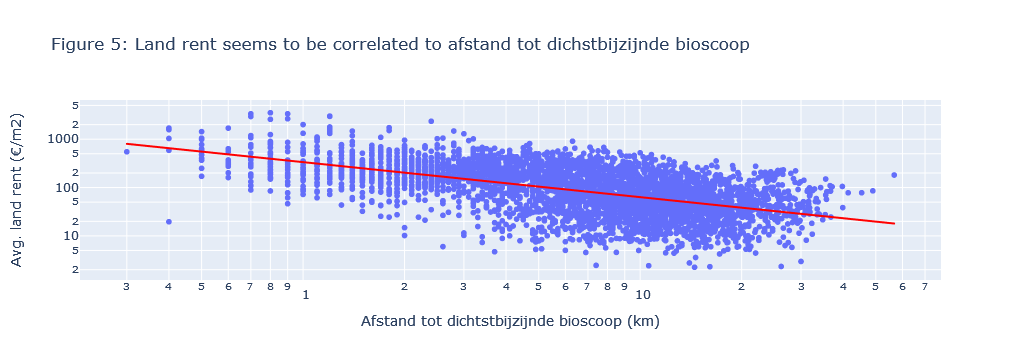

In [8]:
plot_relation(data, 'AFS_BIOS', 'Figure 5: Land rent seems to be correlated to afstand tot dichstbijzijnde bioscoop')

**Conclusions**
- Figure 3 shows a strong positive correlation between the average land rent and population density within the Netherlands.
- Figure 4 shows a weaker positive correlation between the average land rent and population density when only looking at data with a high urbanization rating. This means that the strong positive correlation seen in Figure 3 is most likely caused by the correlation between cities and the countryside instead of correlation within cities.
- Figure 5 shows a strong negative correlation between the average land rent and distance to the nearest cinema (```afstand tot dichtsbijzijnde bioscoop```).

## Chapter 2: Linear Regression models
### 2.1 Coefficients in a Linear Regression model
There seem to be many correlations between statistics and land rents. It is however always important to consider whether a correlation equates to a causation, as other statistics could cause the apparent correlation.

For better analysis of causality, Linear Regression can be used for multivariate analysis of effects on land rents compared to the univariate analysis of a simple scatterplot. This Linear Regression yields the coefficients for variables, which is the effect of changing only that variable on the land rents.

In [9]:
def coeff_df(dataset, m):
    '''Fit a Linear Regression model of factors m of dataset and return the R^2 score and a DataFrame of coefficients'''
    X = dataset.dropna(subset=m)[m]
    y = dataset.dropna(subset=m)['p_m2_FE']
    reg = LinearRegression().fit(X, y)
    
    return reg.score(X,y), pd.DataFrame(reg.coef_, X.columns, columns=['Coefficients'])

In [10]:
score, coeff = coeff_df(data, m[0])
coeff['Variable'] = pd.Series({x: data_labels.get(x) for x in coeff.index})
print(f'R^2 = {round(score, 2)}')
display(coeff)

R^2 = 0.61


Coefficients                                           Variable
AFS_BSO        -0.563265  Afstand tot dichtstbijzijnde buitenschoolse op...
AFS_HAPRAK      1.551114  Afstand tot dichtstbijzijnde huisartsenpraktij...
AFS_TRNOVS      0.347566  Afstand tot dichtstbijzijnde belangrijk overst...
AFS_ONDHV      -1.903165  Afstand tot dichtstbijzijnde school HAVO/VWO (km)
AFS_WARENH     -1.322460        Afstand tot dichtstbijzijnde warenhuis (km)
AFS_APOTH      -2.320287         Afstand tot dichtstbijzijnde apotheek (km)
AFS_TREINS      0.812268     Afstand tot dichtstbijzijnde treinstation (km)
AFS_BRANDW     -4.182794  Afstand tot dichtstbijzijnde brandweerkazerne ...
AFS_CAFE        7.000550             Afstand tot dichtstbijzijnde café (km)
AFS_POP        -2.084325        Afstand tot dichtstbijzijnde poppodium (km)
AFS_KDV        -7.170467  Afstand tot dichtstbijzijnde kinderdagverblijf...
AV5_HAPRAK      6.988565  Aantal huisartsenpraktijken binnen 5 kilometer...
AFS_HOTEL      -2.249264            Afstand tot dichtstbijzijnde hotel (km)
AFS_ONDBAS      0.203081      Afstand tot dichtstbijzijnde basisschool (km)
AFS_ZONBNK      0.610644        Afstand tot dichtstbijzijnde zonnebank (km)
AFS_CAFTAR      0.225315        Afstand tot dichtstbijzijnde cafetaria (km)
AFS_ONDVRT    -10.294759  Afstand tot dichtstbijzijnde voortgezet onderw...
AFS_SAUNA       0.735855            Afstand tot dichtstbijzijnde sauna (km)
AFS_PODIUM     -0.579590  Afstand tot dichtstbijzijnde locatie podiumkun...
AV5_ONDBAS     -4.886903    Aantal basisscholen binnen 5 kilometer (aantal)
AFS_OPRIT       2.968217  Afstand tot dichtstbijzijnde oprit hoofdverkee...
OAD             0.072518      Omgevingsadressendichtheid (adressen per km2)
AV5_SUPERM      2.304458  Aantal grote supermarkten binnen 5 kilometer (...
AF_IJSBAAN     -0.493930     Afstand tot dichtstbijzijnde kunstijsbaan (km)
AFS_MUS        -1.538935                            Afstand tot museum (km)
AFS_ONDVMB      9.144559      Afstand tot dichtstbijzijnde school VMBO (km)
AFS_ZWEMB       1.233340          Afstand tot dichtstbijzijnde zwembad (km)
AFS_SUPERM     -0.940036  Afstand tot dichtstbijzijnde grote supermarkt ...
AFS_ATTRAC     -0.405665    Afstand tot dichtstbijzijnde attractiepark (km)
AFS_BIOS        0.244648         Afstand tot dichtstbijzijnde bioscoop (km)
AFS_HAPOST      1.199484   Afstand tot dichtstbijzijnde huisartsenpost (km)
AV5_ONDVRT     -4.674024  Aantal scholen voortgezet onderwijs binnen 5 k...
AFS_DAGLMD     -1.457968  Afstand tot dichtstbijzijnde overige dagelijks...
AFS_BIBLIO      1.942149      Afstand tot dichtstbijzijnde bibliotheek (km)
AFS_ZIEK_E      0.451967  Afstand tot dichtstbijzijnde ziekenhuis excl. ...
AFS_ZIEK_I     -1.031361  Afstand tot dichtstbijzijnde ziekenhuis incl. ...
G_ELEK_WON      0.004568             Gemiddeld elektriciteitsverbruik (kWh)

**Conclusion**
- The table shows that distance to the nearest cinema (```AFS_BIOS```, ```afstand tot dichtsbijzijnde bioscoop```) actually has a positive effect on land rents, despite the negative correlation apparent in Figure 5. This positive number could also be the effect of the trend not being linear, in which case Linear Regression gives wrong results.
- Univariate analysis is not a useful metric for analysis of the effect of specific factors as this example showed.

### 2.2 Decomposition analysis
The Linear Regression model can be used to decompose the effect that factors have on land rents in a specific location compared to another location (in this case the average). 

The **effect of a factor on land rents** is calculated by substracting the *predicted land rent with the score of the factor being the median value* from the *predicted land rent with the score of the factor being the true value*.

The **difference in land rents** is calculated by substracting the *average land rent* from the *actual land rent*.

The **residual** is the *difference in land rents* that is not explained by the effect of the calculated factors. The residual is a measure of the accuracy of the Linear Regression model used.

In [14]:
def decompose(location, m):
    '''Plot the decomposition of the land rent increase compared to the average as effected by factors m'''
    m = list(m)
    dataset = data.copy()
    X = dataset.dropna(subset=m)[m]
    y = dataset.dropna(subset=m)["p_m2_FE"]
    reg = LinearRegression().fit(X, y)

    X = dataset[m]

    x_plot = []
    y_plot = []

    for factor in m:
        X_compare = X.copy()
        X_compare.loc[location, factor] = dataset[factor].mean()

        predict = reg.predict(X.loc[[location]])
        predict_mean = reg.predict(X_compare.loc[[location]])

        x_plot.append(predict[0] - predict_mean[0])
        y_plot.append(data_labels.get(factor, factor))

    x_delta = dataset.loc[location, "p_m2_FE"] - dataset["p_m2_FE"].mean()

    residual = x_delta - sum(x_plot)

    x_plot.append(residual)
    y_plot.append("Residual")

    x_plot.append(x_delta)
    y_plot.append("Difference in land rents")

    fig = go.Figure(go.Bar(x=x_plot, y=y_plot, orientation="h"))
    fig.update_yaxes(tickmode="linear")
    fig["data"][0].width = 1
    title = f"Effect of factors on land rents in zip code {str(location)} compared to average"
    fig.update_layout(title_text=title)
    fig.show()


def factor_map(factor, m):
    '''Plot a map which plots the effect of factor as determined by a Linear Regression model which takes m as input'''
    dataset = data.copy()
    m = list(m)
    X = dataset.dropna(subset=m)[m]
    y = dataset.dropna(subset=m)["p_m2_FE"]
    reg = LinearRegression().fit(X, y)

    X = dataset[m]

    plot = {"PC": [], "Delta": [], "Geometry": []}

    for location in list(dataset.index):
        X_compare = X.copy()
        X_compare.loc[location, factor] = dataset[factor].mean()

        predict = reg.predict(X.loc[[location]])
        predict_mean = reg.predict(X_compare.loc[[location]])

        dataset.loc[location, factor] = predict[0] - predict_mean[0]

    dataset.plot(
        column=factor,
        legend=True,
    )
    ax = plt.gca()
    ax.set_title("Effect of " + data_labels.get(factor, factor) + " on land rents")
    ax.set_axis_off()
    plt.show()


## Decomposition dashboard
This dashboard plots the effect of different factors on the difference of the land rent in a postal code compared to the country average.

**Instructions**
- Enter a **zip code** in the Netherlands. *Any zip code can be entered.*
- Optional: **Add or remove explanatory variables**. The default contains some statistics that give an average Linear Regression model. This can be used to optimize the Linear Regression model or look at different explanatory variables. *Minimum number of factors: 2.*
    - Note: More explanatory variables does not necissarily mean a better model. Try to prevent having multiple similar variables as this makes the Linear Regression model less accurate.
    

In [15]:
interact_manual(decompose,
                location=widgets.BoundedIntText(
    value=1111,
    min=1000,
    max=9999,
    step=1,
    description='Zip code:',
    disabled=False
),
                m = widgets.TagsInput(
    allowed_tags=m[0],
    value=['AV5_SUPERM', 'AFS_OPRIT', 'AFS_TREINS', 'AV5_HAPRAK', 'AV5_ONDBAS', 'AV5_ONDVRT', 'AFS_PODIUM', 'OAD'],
    description='Factors:',
    disabled=False
))



interactive(children=(BoundedIntText(value=1111, description='Zip code:', max=9999, min=1000), TagsInput(value…

<function __main__.decompose(location, m)>

## Effect dashboard
This dashboard plots a map that shows the effect of the selected factor on the land rent in all postal codes. The effect is calculated using a Linear Regression model that uses the selected factors.

**Instructions**
- Enter an **explanatory variable**. *The factor must be in the Linear Regression model*
- Optional: **Add or remove explanatory variables**. The default contains some statistics that give an average Linear Regression model. This can be used to optimize the Linear Regression model or look at different explanatory variables. *Minimum number of factors: 2.*
    - Note: More explanatory variables does not necissarily mean a better model. Try to prevent having multiple similar variables as this makes the Linear Regression model less accurate.
    

In [13]:
interact_manual(
    factor_map,
    factor=widgets.Combobox(
        placeholder="Choose factor",
        options=m[0],
        description="Factor:",
    ),
    m=widgets.TagsInput(
        allowed_tags=m[0],
        value=[
            "AV5_SUPERM",
            "AFS_OPRIT",
            "AFS_TREINS",
            "AV5_HAPRAK",
            "AV5_ONDBAS",
            "AV5_ONDVRT",
            "AFS_PODIUM",
            "OAD",
        ],
    ),
)


interactive(children=(Combobox(value='', description='Factor:', options=('AFS_BSO', 'AFS_HAPRAK', 'AFS_TRNOVS'…

<function __main__.factor_map(factor, m)>